In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [213]:
path = r"D:\AI_road_map\python\dataSets\first inten project.csv"
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [214]:
data.columns

Index(['Booking_ID', 'number of adults', 'number of children',
       'number of weekend nights', 'number of week nights', 'type of meal',
       'car parking space', 'room type', 'lead time', 'market segment type',
       'repeated', 'P-C', 'P-not-C', 'average price ', 'special requests',
       'date of reservation', 'booking status'],
      dtype='object')

In [215]:
data.duplicated().value_counts()

False    36285
Name: count, dtype: int64

In [216]:
def month_arr(date):
    parts = date.split('/')
    if len(parts) == 1:
        parts = date.split('-')
        mon = parts[1]
        day = parts[2]
    else:
        mon = parts[0]
        day = parts[1]
    return mon,day

In [217]:
def more_than_year(data):
    year = 0
    while data >12 :
        data = data-12
        year += 1
    return data

In [218]:
data[['month', 'day']] = pd.DataFrame(data['date of reservation'].apply(month_arr).tolist(), index=data.index)
data['month'] = data['month'].astype(int)

data['day'] = data['day'].astype(int)
data['month of arrive'] = (data['month'] + (data['day'] + data['lead time'])//30)

data['month of arrive'] = pd.DataFrame(data['month of arrive'].apply(more_than_year).tolist(), index=data.index)

In [219]:
data.drop(["Booking_ID","date of reservation","day","month"],axis=1,inplace=True)

In [220]:
data = pd.get_dummies(data,columns=["type of meal" , "room type","market segment type" ],dtype='int8')
data['booking status'] = data['booking status'] != 'Canceled'
data['booking status'] = data['booking status'].astype('int8')

In [ ]:
def remove_outliers_iqr(data, column):

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


In [ ]:
from scipy.stats import zscore

def remove_outliers_zscore(data, column, threshold=3):

    z_scores = zscore(data[column])
    mask = abs(z_scores) < threshold
    return data[mask]


In [223]:
data = remove_outliers_iqr(data, 'lead time')
data = remove_outliers_zscore(data, 'average price ')

In [224]:
X = data.drop(["booking status",'market segment type_Offline','type of meal_Not Selected'
            ,"type of meal_Meal Plan 3",'room type_Room_Type 2','room type_Room_Type 3'
            ,'room type_Room_Type 5','market segment type_Aviation','room type_Room_Type 4'],axis=1)
Y = data["booking status"]

In [225]:
X_train,x_test,y_train,y_test = train_test_split(X,Y ,train_size=0.75, test_size=0.25 ,random_state=42)

In [226]:
from sklearn.feature_selection import SelectKBest, chi2
X_train['lead_time_bin'] = pd.qcut(X_train['lead time'], q=4, labels=[0, 1, 2, 3])
X_train['avg_bin'] = pd.qcut(X_train['average price '], q=4, labels=[0, 1, 2, 3])
selector = SelectKBest(score_func=chi2, k=10)
X_new = selector.fit_transform(X_train, y_train)

scores = selector.scores_

pd.DataFrame({'features':X_train.columns,'chi2':scores})

,features,chi2
0,number of adults,24.724407
1,number of children,43.642557
2,number of weekend nights,157.892359
3,number of week nights,221.997432
4,car parking space,158.648735
5,lead time,301793.121414
6,repeated,294.095000
7,P-C,180.979632
8,P-not-C,1870.153843
9,average price,5850.718556


In [227]:
X_train = X_train.drop(["lead_time_bin"],axis=1)
X_train = X_train.drop(["avg_bin"],axis=1)

In [ ]:
import pandas as pd
from scipy.stats import fisher_exact
for i in range(20):

    contingency = pd.crosstab(X_train.iloc[:,i], y_train)


    odds_ratio, p_value = fisher_exact(contingency)

    print(f"P-value of {X_train.columns[i]}: ",p_value)

P-value of number of adults:  0.0001
P-value of number of children:  0.0001
P-value of number of weekend nights:  0.0001
P-value of number of week nights:  0.0001
P-value of car parking space:  1.1131547053844387e-44
P-value of lead time:  0.8749
P-value of repeated:  2.4858724931786464e-100
P-value of P-C:  0.0001
P-value of P-not-C:  0.0001
P-value of average price :  1.0
P-value of special requests:  0.0001
P-value of month of arrive:  0.0001
P-value of type of meal_Meal Plan 1:  2.7521440836559046e-09
P-value of type of meal_Meal Plan 2:  1.1256509971482457e-06
P-value of room type_Room_Type 1:  7.575647983825406e-11
P-value of room type_Room_Type 6:  3.030843517270278e-06
P-value of room type_Room_Type 7:  0.011701620591231858
P-value of market segment type_Complementary:  2.70535788853197e-48
P-value of market segment type_Corporate:  1.1695320983758372e-77
P-value of market segment type_Online:  1.7046850706442354e-118


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(x_test)

In [230]:
from sklearn.linear_model import LinearRegression
def compute_vif(X_df):
    vif_dict = {}
    for col in X_df.columns:
        X_other = X_df.drop(columns=[col])
        y_target = X_df[col]
        model = LinearRegression().fit(X_other, y_target)
        r2 = model.score(X_other, y_target)
        tolerance = 1 - r2
        vif = 1 / tolerance if tolerance != 0 else float('inf')
        vif_dict[col] = round(vif, 2)
    return pd.DataFrame({'Feature': vif_dict.keys(), 'VIF': vif_dict.values()})
    
vif_df = compute_vif(X)
print(vif_df)


                              Feature   VIF
0                    number of adults  1.31
1                  number of children  1.69
2            number of weekend nights  1.07
3               number of week nights  1.10
4                   car parking space  1.03
5                           lead time  1.19
6                            repeated  1.76
7                                 P-C  1.35
8                             P-not-C  1.61
9                      average price   1.77
10                   special requests  1.23
11                    month of arrive  1.06
12           type of meal_Meal Plan 1  1.70
13           type of meal_Meal Plan 2  1.74
14              room type_Room_Type 1  1.41
15              room type_Room_Type 6  1.72
16              room type_Room_Type 7  1.06
17  market segment type_Complementary  1.32
18      market segment type_Corporate  1.52
19         market segment type_Online  1.76


In [232]:
# model = LogisticRegression(class_weight="balanced",max_iter=200)

In [233]:
# model = LogisticRegression(class_weight="balanced",max_iter=200,random_state=0)
# model.fit(X_train_scaled,y_train)


In [251]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model1 = DecisionTreeClassifier(random_state=42,max_depth=12)
model.fit(X_train_scaled,y_train)
model1.fit(X_train_scaled,y_train)


DecisionTreeClassifier(max_depth=12, random_state=42)

In [253]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)
accuracy_score(y_test,y_pred),accuracy_score(y_train,y_pred_train)

(0.8932038834951457, 0.9937194158671444)

In [252]:
y_pred1 = model1.predict(X_test_scaled)
y_pred_train1 = model1.predict(X_train_scaled)
accuracy_score(y_test,y_pred1),accuracy_score(y_train,y_pred_train1)

(0.8689320388349514, 0.8982005933803414)

In [256]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Canceled", "Not Canceled"]))


Classification Report:
              precision    recall  f1-score   support

    Canceled       0.86      0.78      0.82      2665
Not Canceled       0.91      0.94      0.92      5987

    accuracy                           0.89      8652
   macro avg       0.88      0.86      0.87      8652
weighted avg       0.89      0.89      0.89      8652



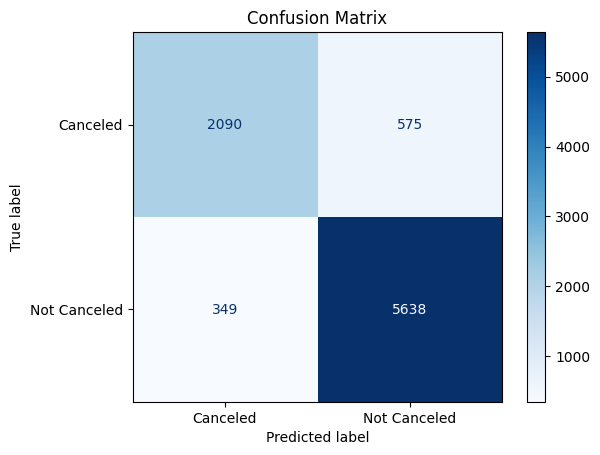

In [249]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Canceled", "Not Canceled"],
    cmap='Blues'
)
plt.title("Confusion Matrix")
plt.show()
